# Boosting and Stacking Exercises

# (Gradient) Boosting

###Decomposing a complicated function (model) into simpler subfunctions ("weak" models)

## https://explained.ai/gradient-boosting/descent.html

## Boosting as gradient descent in prediction (function) space

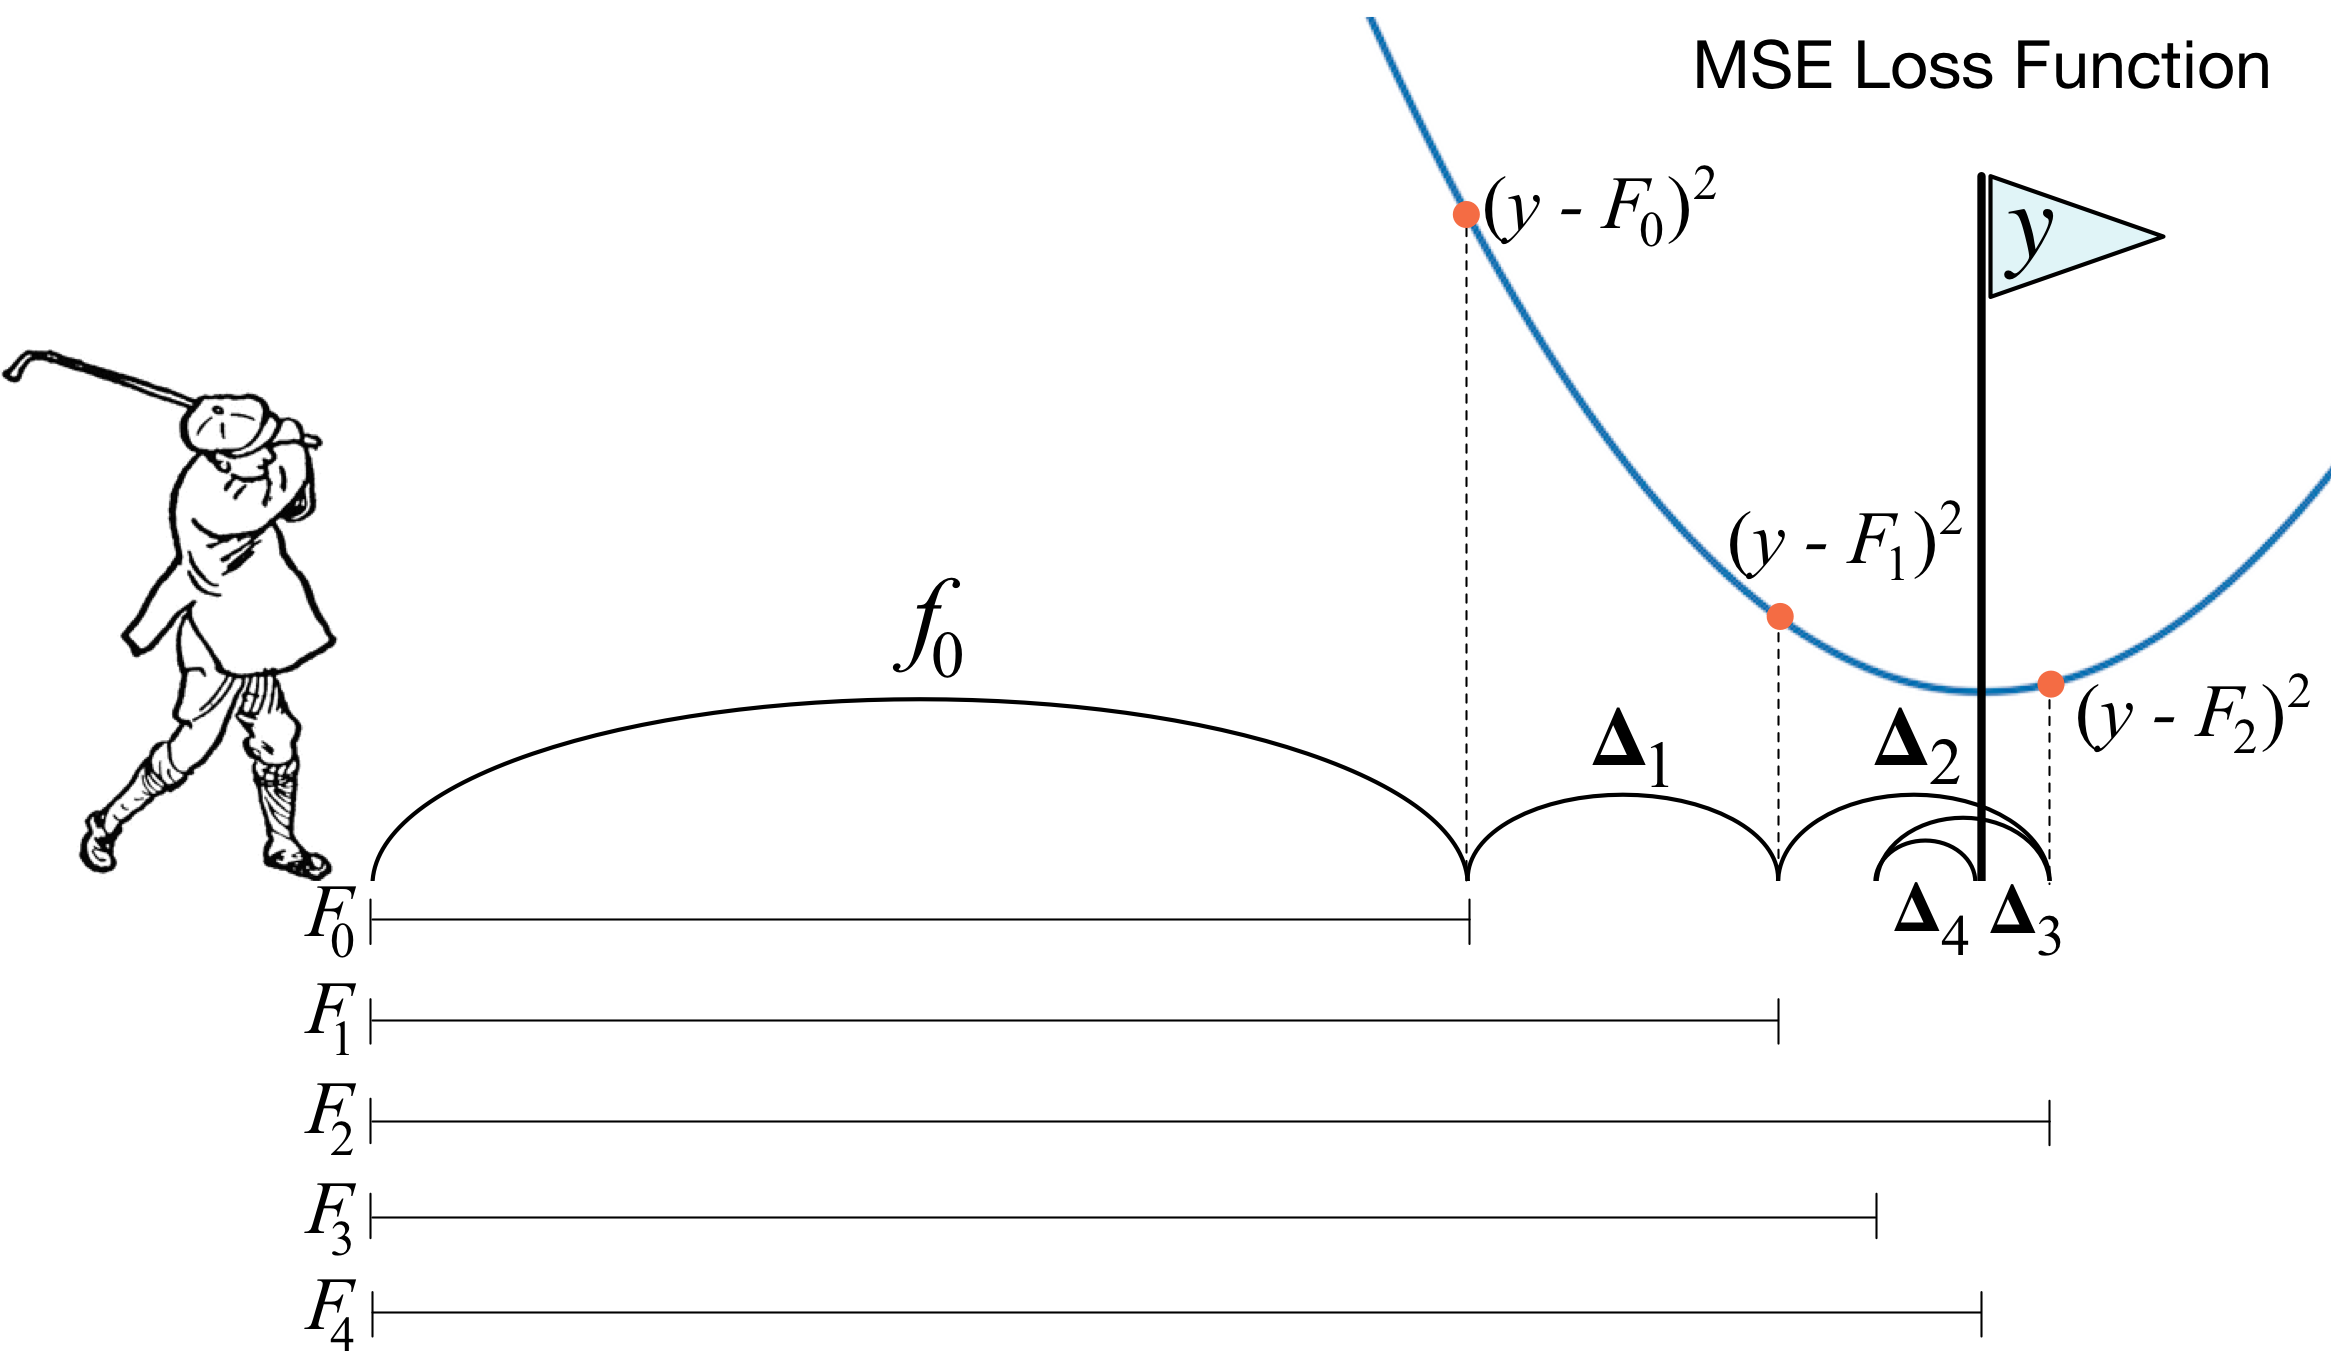

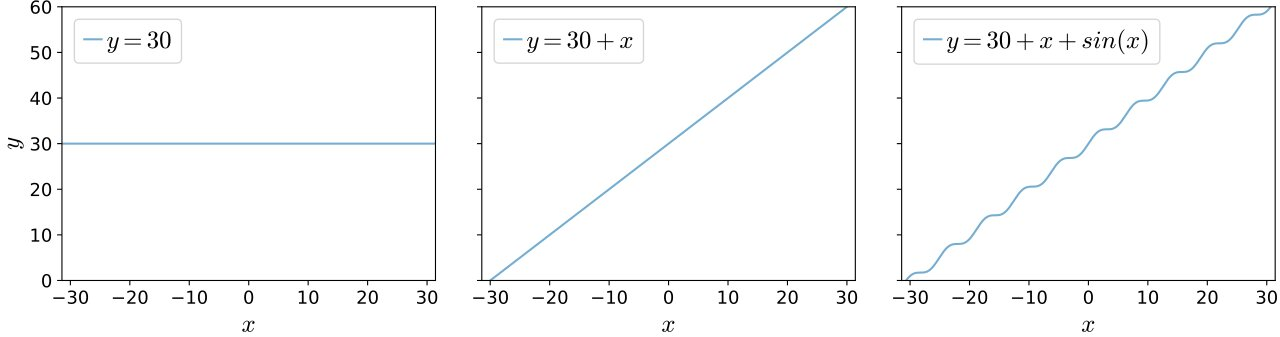

# Gradient Boosting Regressor Tree  - Mathematical formulation

## mostly from https://scikit-learn.org/stable/modules/ensemble.html


$\hat{y_i} = F_M(x_i) = \sum_{m=1}^{M} h_m(x_i)$


## where $h_m$ are estimators called weak learners in the context of boosting. 

## GBRT is built in a greedy fashion:

$F_m(x) = F_{m-1}(x) + h_m(x)$

## $F_0$ is chosen as the constant that minimizes the loss: for a least-squares loss, this is the empirical mean of the target values.

## The newly added tree $h_m$ is fitted in order to minimize a sum of losses $L_m$, given the previous ensemble $F_{m-1}$:

## $h_m =  \arg\min_{h} L_m = \arg\min_{h} \sum_{i=1}^{n}
l(y_i, F_{m-1}(x_i) + h(x_i))$,

##where $l(y_i, F(x_i))$  is the loss (defined later)

## Using a first-order Taylor approximation, the value of $l$ can be approximated as follows:

## $l(y_i, F_{m-1}(x_i) + h_m(x_i)) \approx
l(y_i, F_{m-1}(x_i))
+ h_m(x_i)
\left[ \frac{\partial l(y_i, F(x_i))}{\partial F(x_i)} \right]_{F=F_{m - 1}}$

## A first-order Taylor approximation says that $l(z) \approx l(a) + (z - a) \frac{\partial l(a)}{\partial a}$

## $z$ corresponds to $F_{m - 1}(x_i) + h_m(x_i)$

## and $a$ corresponds to $F_{m-1}(x_i)$

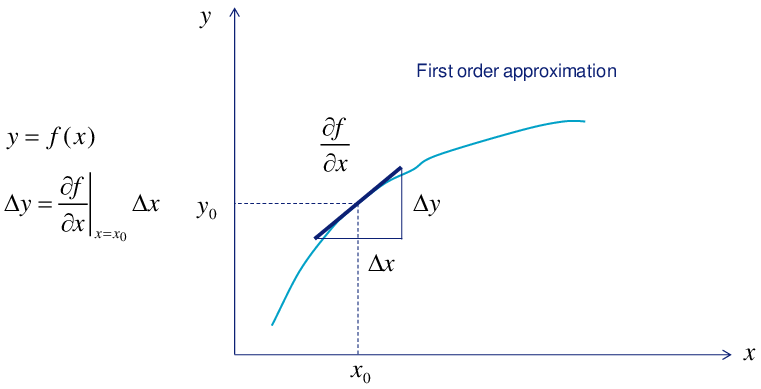

## The quantity $\left[ \frac{\partial l(y_i, F(x_i))}{\partial F(x_i)}
\right]_{F=F_{m - 1}}$
 
## is the derivative of the loss with respect to its second parameter, evaluated at $F_{m-1}(x)$. It is easy to compute for any given $F_{m-1}(x)$ in a closed form since the loss is differentiable. We will denote it by $g_i$.

##For the MSE the derivative is simply the residual:
##$loss_{MSE} = \frac{1}{2} \sum_{i=1}^n \left( y_i - F(\mathbf{x}_i) \right)^2$

##$g_i = \frac{\partial l(y_i, F(x_i))}{\partial F(x_i)}
 = -(y_i - F(\mathbf{x}_i))$

##Removing the constant terms, we have:
##$h_m \approx \arg\min_{h} \sum_{i=1}^{n} h(x_i) g_i$

## This is minimized if $h(x_i)$ is fitted to predict a value that is proportional to the negative gradient $-g_i$. Therefore, at each iteration, the estimator $h_m$ is fitted to predict the negative gradients of the samples. The gradients are updated at each iteration. This can be considered as some kind of gradient descent in a functional space.

#This notebook contains code for Gradient Boosting from the book Ensemble Methods for Machine Learning: 
#https://nbviewer.org/github/gkunapuli/ensemble-methods-notebooks/blob/master/Ch5.2-gradient-boosting.ipynb?flush_cache=True

#This notebook contains code for Adaboost from the book Ensemble Methods for Machine Learning:
#https://nbviewer.org/github/gkunapuli/ensemble-methods-notebooks/blob/master/Ch4.1and4.2-sequential-ensembles-and-Adaboost.ipynb?flush_cache=True

#Stacking

#These notebook contains code for Stacking from the book Ensemble Methods for Machine Learning:

#https://nbviewer.org/github/gkunapuli/ensemble-methods-notebooks/blob/master/Ch3.1-base-estimators-for-heterogeneous-ensembles.ipynb?flush_cache=True

#https://nbviewer.org/github/gkunapuli/ensemble-methods-notebooks/blob/master/Ch3.2-combining-predictions-by-weighting.ipynb?flush_cache=True

#https://nbviewer.org/github/gkunapuli/ensemble-methods-notebooks/blob/master/Ch3.3-combining-predictions-by-meta-learning.ipynb?flush_cache=True

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website above.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Question 1

* Import the data from the file `Human_Activity_Recognition_Using_Smartphones_Data.csv` and examine the shape and data types. For the data types, there will be too many to list each column separately. Rather, aggregate the types by count.
* Determine if the float columns need to be scaled.

In [2]:
import pandas as pd
import numpy as np

filepath = 'https://raw.githubusercontent.com/yoel2000/Computational-learning/main/Data/Human_Activity_Recognition_Using_Smartphones_Data.csv'
data = pd.read_csv(filepath, sep=',')

The data has quite a few predictor columns.

In [3]:
data.shape

(10299, 562)

And they're all float values. The only non-float is the categories column, which is what's being predicted.

In [4]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [5]:
data.head

<bound method NDFrame.head of        tBodyAcc-mean()-X  ...          Activity
0               0.288585  ...          STANDING
1               0.278419  ...          STANDING
2               0.279653  ...          STANDING
3               0.279174  ...          STANDING
4               0.276629  ...          STANDING
...                  ...  ...               ...
10294           0.310155  ...  WALKING_UPSTAIRS
10295           0.363385  ...  WALKING_UPSTAIRS
10296           0.349966  ...  WALKING_UPSTAIRS
10297           0.237594  ...  WALKING_UPSTAIRS
10298           0.153627  ...  WALKING_UPSTAIRS

[10299 rows x 562 columns]>

The minimum and maximum value for the float columns is -1.0 and 1.0, respectively. However, scaling is never required for tree-based methods.

In [6]:
# Mask to select float columns
float_columns = (data.dtypes == np.float)

# Verify that the maximum of all float columns is 1.0
print( (data.loc[:,float_columns].max()==1.0).all() )

# Verify that the minimum of all float columns is -1.0
print( (data.loc[:,float_columns].min()==-1.0).all() )

True
True


## Question 2

* Integer encode the activities.
* Split the data into train and test data sets. Decide if the data will be stratified or not during the train/test split.

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['Activity'] = le.fit_transform(data['Activity']) # The data is converted into Integer.

le.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [8]:
data.Activity.unique()

array([2, 1, 0, 3, 4, 5])

**NOTE**: We are about to create training and test sets from `data`. On those datasets, we are going to run grid searches over many choices of parameters. This can take some time. In order to shorten the grid search time, feel free to downsample `data` and create `X_train, X_test, y_train, y_test` from the downsampled dataset.

Now split the data into train and test data sets. A stratified split was not used here. If there are issues with any of the error metrics on the test set, it can be a good idea to start model fitting over using a stratified split. Boosting is a pretty powerful model, though, so it may not be necessary in this case.

In [9]:
from sklearn.model_selection import train_test_split

# Alternatively, we could stratify the categories in the split, as was done previously
feature_columns = [x for x in data.columns if x != 'Activity']

X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data['Activity'],
                 test_size=0.3, random_state=42)


In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7209, 561), (7209,), (3090, 561), (3090,))

## Question 3

* Fit gradient boosted tree models with all parameters set to their defaults the following tree numbers (`n_estimators = [25, 50, 100, 200, 400]`) and evaluate the accuracy on the test data for each of these models. 
* Plot the accuracy as a function of estimator number.

**Note:** This question may take some time to execute, depending on how many different values are fit for estimators. Setting `max_features=4` in the gradient boosting classifier will increase the convergence rate.

Also, this is similar to question 3 from week 9, except that there is no such thing as out-of-bag error for boosted models. And the `warm_flag=True` setting has a bug in the gradient boosted model, so don't use it. Simply create the model inside the `for` loop and set the number of estimators at this time. This will make the fitting take a little longer. Additionally, boosting models tend to take longer to fit than bagged ones because the decision stumps must be fit successively.

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

# Iterate through all of the possibilities for number of estimators
tree_list = [25, 50, 100, 200, 400]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, 
                                     subsample=0.5,
                                     max_features=4,
                                     random_state=42)

    # Fit the model
    GBC.fit(X_train.values, y_train.values)
    y_pred = GBC.predict(X_test)

    # Get the error
    error = 1. - accuracy_score(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarn

,error
n_trees,
15.0,0.106472
50.0,0.045307
100.0,0.026537
200.0,0.017152
400.0,0.012945


Now plot the result.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

In [13]:
!pip install seaborn

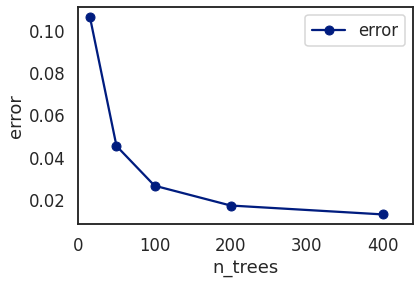

In [14]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

# Create the plot
ax = error_df.plot(marker='o')

# Set parameters
ax.set(xlabel='n_trees', ylabel='error')
ax.set_xlim(0, max(error_df.index)*1.1);



> The error looks like it has stabilized around 100-150 trees.



## Question 4

* Using a grid search with cross-validation, fit a new gradient boosted classifier with the a list of estimators, similar to question 3. Also consider  varying the learning rates (0.1, 0.01, 0.001, etc.), the subsampling value (1.0 or 0.5), and the number of maximum features (1, 2, etc.).
* Examine the parameters of the best fit model.
* Calculate relevant error metrics on this model and examine the confusion matrix.

**Note:** this question may take some time to execute, depending on how many features are associated with the grid search. It is recommended to start with only a few to ensure everything is working correctly and then add more features. Setting `max_features=4` in the gradient boosting classifier will increase the convergence rate.

In [15]:
from sklearn.model_selection import GridSearchCV

# The parameters to be fit--only n_estimators and learning rate
# have been varied here for simplicity
param_grid = {'n_estimators': [200, 400],
              'learning_rate': [0.1, 0.01]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(subsample=0.5,
                                                 max_features=4,
                                                 random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In [16]:
# The best model
GV_GBC.best_estimator_

GradientBoostingClassifier(max_features=4, n_estimators=400, random_state=42,
                           subsample=0.5)

The error metrics. Classification report is particularly convenient for multi-class cases.

In [17]:
from sklearn.metrics import classification_report

y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.97      0.97      0.97       558
           2       0.97      0.97      0.97       550
           3       1.00      1.00      1.00       539
           4       0.99      1.00      1.00       418
           5       1.00      0.99      0.99       428

    accuracy                           0.99      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.99      0.99      0.99      3090





> We see the different metrics of all the 6 classes.



The confusion matrix. Note that the gradient boosted model has a little trouble distinguishing between activity class 1 and 2.

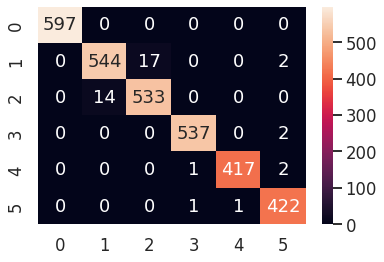

In [18]:
from sklearn.metrics import confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

## Question 5

* Create an AdaBoost model and fit it using grid search, much like question 4. Try a range of estimators between 100 and 200.
* Compare the errors from AdaBoost to those from the GradientBoostedClassifier.

**NOTE:** Setting `max_features=4` in the decision tree classifier used as the base classifier for AdaBoost will increase the convergence rate.

In [19]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_features=4))

param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC,
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train, y_train)

The best model.

In [20]:
# The best model
GV_ABC.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_features=4),
                   learning_rate=0.001, n_estimators=100)

The error metrics. Note that the issues with class 1 and 2 appear to have become more problematic and now include class 0. Also note other issues for classes 3 - 5. AdaBoost is very sensitive to outliers, so that could be the problem here.

In [21]:
y_pred = GV_ABC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79       592
           1       0.68      0.66      0.67       576
           2       0.72      0.74      0.73       532
           3       0.88      0.88      0.88       539
           4       0.83      0.88      0.85       394
           5       0.86      0.80      0.83       457

    accuracy                           0.79      3090
   macro avg       0.79      0.79      0.79      3090
weighted avg       0.79      0.79      0.79      3090



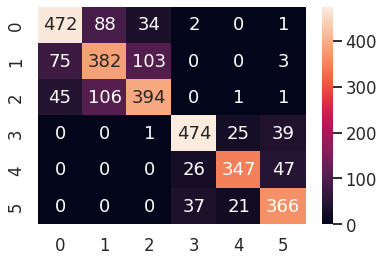

In [22]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')



> The difference between the class 1 and class 2 is very small and we can see it in the matrix confusion.



## Question 6

* Fit a logistic regression model with regularization. This can be a replica of a model that worked well in the exercises from week 5.
* Using `VotingClassifier`, fit the logistic regression model along with either the GratientBoostedClassifier or the AdaBoost model (or both) from questions 4 and 5.
* Determine the error as before and compare the results to the appropriate gradient boosted model(s).
* Plot the confusion matrix for the best model created in this set of exercises.

In [23]:
from sklearn.linear_model import LogisticRegressionCV

# L2 regularized logistic regression
LR_L2 = LogisticRegressionCV(Cs=5, cv=4, penalty='l2').fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Check the errors and confusion matrix for the logistic regression model.

In [24]:
y_pred = LR_L2.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       598
           1       0.95      0.95      0.95       560
           2       0.95      0.96      0.95       545
           3       1.00      0.99      1.00       542
           4       0.99      1.00      0.99       414
           5       1.00      0.98      0.99       431

    accuracy                           0.98      3090
   macro avg       0.98      0.98      0.98      3090
weighted avg       0.98      0.98      0.98      3090



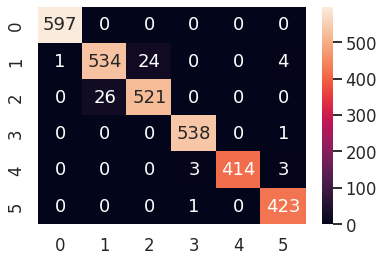

In [25]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

And now the stacked model.

In [26]:
from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('LR_L2', LR_L2), ('GBC', GV_GBC)]

# Though it wasn't done here, it is often desirable to train 
# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Finally the error on the voting classifier. We do a little better here than with either logistic regression or gradient boosted trees alone. However, the fact that logistic regression does almost as well as gradient boosted trees is an important reminder that it's good practice to try the simplest model first. In some cases, its performance will be good enough.

In [27]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.96      0.96      0.96       563
           2       0.97      0.96      0.96       547
           3       0.99      1.00      1.00       539
           4       1.00      1.00      1.00       420
           5       0.99      1.00      0.99       424

    accuracy                           0.98      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.98      0.98      0.98      3090



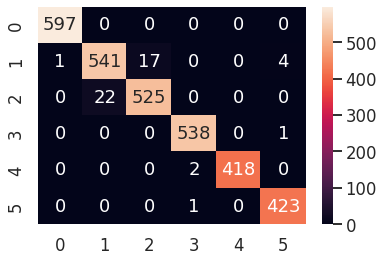

In [28]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

#Homework

## Question 7
* Import the iris data and examine the features.
* We will be using all of them to predict species, but the species feature will need to be integer encoded.
* Download iris.csv from https://www.kaggle.com/uciml/iris/data/  and rename it as Iris_Data.csv

In [34]:
filepath = 'https://raw.githubusercontent.com/yoel2000/Computational-learning/main/Data/Iris_Data.csv'
data = pd.read_csv(filepath, sep=',')

In [35]:
data.head

<bound method NDFrame.head of      sepal_length  sepal_width  petal_length  petal_width         species
0             5.1          3.5           1.4          0.2     Iris-setosa
1             4.9          3.0           1.4          0.2     Iris-setosa
2             4.7          3.2           1.3          0.2     Iris-setosa
3             4.6          3.1           1.5          0.2     Iris-setosa
4             5.0          3.6           1.4          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

[150 rows x 5 columns]>

Convert the species feature to an integer. This is a quick way to do it using Pandas.

In [36]:
data.species = data.species.astype("category").cat.codes
data.head

<bound method NDFrame.head of      sepal_length  sepal_width  petal_length  petal_width  species
0             5.1          3.5           1.4          0.2        0
1             4.9          3.0           1.4          0.2        0
2             4.7          3.2           1.3          0.2        0
3             4.6          3.1           1.5          0.2        0
4             5.0          3.6           1.4          0.2        0
..            ...          ...           ...          ...      ...
145           6.7          3.0           5.2          2.3        2
146           6.3          2.5           5.0          1.9        2
147           6.5          3.0           5.2          2.0        2
148           6.2          3.4           5.4          2.3        2
149           5.9          3.0           5.1          1.8        2

[150 rows x 5 columns]>

In [37]:
filepath = 'https://raw.githubusercontent.com/yoel2000/Computational-learning/main/Data/Iris.csv'
iris_data = pd.read_csv(filepath, sep=',')

In [38]:
iris_data.head

<bound method NDFrame.head of       Id  SepalLengthCm  ...  PetalWidthCm         Species
0      1            5.1  ...           0.2     Iris-setosa
1      2            4.9  ...           0.2     Iris-setosa
2      3            4.7  ...           0.2     Iris-setosa
3      4            4.6  ...           0.2     Iris-setosa
4      5            5.0  ...           0.2     Iris-setosa
..   ...            ...  ...           ...             ...
145  146            6.7  ...           2.3  Iris-virginica
146  147            6.3  ...           1.9  Iris-virginica
147  148            6.5  ...           2.0  Iris-virginica
148  149            6.2  ...           2.3  Iris-virginica
149  150            5.9  ...           1.8  Iris-virginica

[150 rows x 6 columns]>

In [41]:
iris_data.Species = iris_data.Species.astype("category").cat.codes
iris_data.head

<bound method NDFrame.head of       Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  Species
0      1            5.1           3.5            1.4           0.2        0
1      2            4.9           3.0            1.4           0.2        0
2      3            4.7           3.2            1.3           0.2        0
3      4            4.6           3.1            1.5           0.2        0
4      5            5.0           3.6            1.4           0.2        0
..   ...            ...           ...            ...           ...      ...
145  146            6.7           3.0            5.2           2.3        2
146  147            6.3           2.5            5.0           1.9        2
147  148            6.5           3.0            5.2           2.0        2
148  149            6.2           3.4            5.4           2.3        2
149  150            5.9           3.0            5.1           1.8        2

[150 rows x 6 columns]>

## Question 8

* Use `StratifiedShuffleSplit` to split data into train and test sets that are stratified by species. If possible, preserve the indices of the split for question 11 below.
* Check the percent composition of each species level for both the train and test data sets.

In [44]:
# All data columns except for species
feature_cols = [x for x in iris_data.columns if x not in 'Species']
feature_cols

['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

In [47]:
from sklearn.model_selection import StratifiedShuffleSplit

# Split the data into two parts with 1000 points in the test data
# This creates a generator
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=15, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(iris_data[feature_cols], iris_data['Species']))

# Create the data sets
X_train = iris_data.loc[train_idx, feature_cols]
y_train = iris_data.loc[train_idx, 'Species']

X_test = iris_data.loc[test_idx, feature_cols]
y_test = iris_data.loc[test_idx, 'Species']

Now check the percent composition of target class in the train and test iris_data sets.

In [48]:
y_train.value_counts(normalize=True).sort_index()

0    0.333333
1    0.333333
2    0.333333
Name: Species, dtype: float64

In [53]:
y_train.value_counts().sort_index()

0    45
1    45
2    45
Name: Species, dtype: int64

In [49]:
y_test.value_counts(normalize=True).sort_index()

0    0.333333
1    0.333333
2    0.333333
Name: Species, dtype: float64

In [54]:
y_test.value_counts().sort_index()

0    5
1    5
2    5
Name: Species, dtype: int64

## Question 9

* Fit gradient boosted tree models with all parameters set to their defaults the following tree numbers (`n_estimators = [25, 50, 100, 200, 400]`) and evaluate the accuracy on the test data for each of these models. 
* Plot the accuracy as a function of estimator number.

**Note:** This question may take some time to execute, depending on how many different values are fit for estimators. Setting `max_features=4` in the gradient boosting classifier will increase the convergence rate.

Also, this is similar to question 9 from week 9, except that there is no such thing as out-of-bag error for boosted models. And the `warm_flag=True` setting has a bug in the gradient boosted model, so don't use it. Simply create the model inside the `for` loop and set the number of estimators at this time. This will make the fitting take a little longer. Additionally, boosting models tend to take longer to fit than bagged ones because the decision stumps must be fit successively.

In [63]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

# Iterate through all of the possibilities for number of estimators
tree_list = [25, 50, 100, 200, 400]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, 
                                     subsample=0.5,
                                     max_features=1,
                                     random_state=10)

    # Fit the model
    GBC.fit(X_train.values, y_train.values)
    y_pred = GBC.predict(X_test)
    print(y_pred)
    print(y_test)
    # Get the error
    error = 1. - accuracy_score(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


[1 2 2 1 2 0 0 0 2 1 0 2 1 2 0]
58     1
134    2
147    2
69     1
107    2
42     0
38     0
7      0
132    2
75     1
14     0
116    2
51     1
77     1
28     0
Name: Species, dtype: int8


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


[1 2 2 1 2 0 0 0 2 1 0 2 1 2 0]
58     1
134    2
147    2
69     1
107    2
42     0
38     0
7      0
132    2
75     1
14     0
116    2
51     1
77     1
28     0
Name: Species, dtype: int8


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


[1 2 2 1 2 0 0 0 2 1 0 2 1 1 0]
58     1
134    2
147    2
69     1
107    2
42     0
38     0
7      0
132    2
75     1
14     0
116    2
51     1
77     1
28     0
Name: Species, dtype: int8


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


[1 2 2 1 2 0 0 0 2 1 0 2 1 1 0]
58     1
134    2
147    2
69     1
107    2
42     0
38     0
7      0
132    2
75     1
14     0
116    2
51     1
77     1
28     0
Name: Species, dtype: int8
[1 2 2 1 2 0 0 0 2 1 0 2 1 1 0]
58     1
134    2
147    2
69     1
107    2
42     0
38     0
7      0
132    2
75     1
14     0
116    2
51     1
77     1
28     0
Name: Species, dtype: int8


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


,error
n_trees,
25.0,0.066667
50.0,0.066667
100.0,0.000000
200.0,0.000000
400.0,0.000000




> To start having an error greater than 0 I changed a few settings like the max_features which I decreased to 1.



Now plot the result.

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

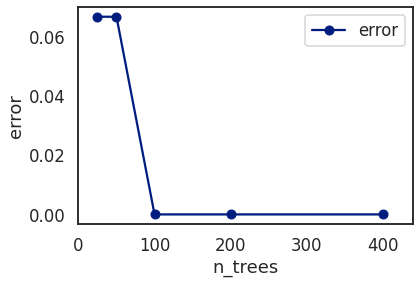

In [64]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

# Create the plot
ax = error_df.plot(marker='o')

# Set parameters
ax.set(xlabel='n_trees', ylabel='error')
ax.set_xlim(0, max(error_df.index)*1.1);

## Question 10

* Using a grid search with cross-validation, fit a new gradient boosted classifier with the a list of estimators, similar to question 9. Also consider  varying the learning rates (0.1, 0.01, 0.001, etc.), the subsampling value (1.0 or 0.5), and the number of maximum features (1, 2, etc.).
* Examine the parameters of the best fit model.
* Calculate relevant error metrics on this model and examine the confusion matrix.

**Note:** this question may take some time to execute, depending on how many features are associated with the grid search. It is recommended to start with only a few to ensure everything is working correctly and then add more features. Setting `max_features=4` in the gradient boosting classifier will increase the convergence rate.

In [65]:
from sklearn.model_selection import GridSearchCV

# The parameters to be fit--only n_estimators and learning rate
# have been varied here for simplicity
param_grid = {'n_estimators': [200, 400],
              'learning_rate': [0.1, 0.01]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(subsample=0.5,
                                                 max_features=1,
                                                 random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In [66]:
# The best model
GV_GBC.best_estimator_

GradientBoostingClassifier(learning_rate=0.01, max_features=1, n_estimators=400,
                           random_state=42, subsample=0.5)

The error metrics. Classification report is particularly convenient for multi-class cases.

In [67]:
from sklearn.metrics import classification_report

y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      1.00      0.89         4
           2       1.00      0.83      0.91         6

    accuracy                           0.93        15
   macro avg       0.93      0.94      0.93        15
weighted avg       0.95      0.93      0.93        15



The confusion matrix. Note that the gradient boosted model has a little trouble distinguishing between species  class 0,1 and 2.

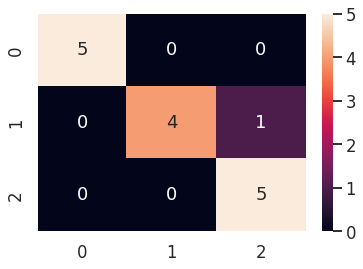

In [68]:
from sklearn.metrics import confusion_matrix


sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

## Question 11

* Create an AdaBoost model and fit it using grid search, much like question 10. Try a range of estimators between 100 and 200.
* Compare the errors from AdaBoost to those from the GradientBoostedClassifier.

**NOTE:** Setting `max_features=4` in the decision tree classifier used as the base classifier for AdaBoost will increase the convergence rate.

In [69]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_features=4))

param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC,
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train, y_train)

The best model.

In [70]:
# The best model
GV_ABC.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_features=4),
                   learning_rate=0.01, n_estimators=150)

The error metrics. Note that the issues with class 0,1 and 2 appear to have become more problematic and now include class 0. AdaBoost is very sensitive to outliers, so that could be the problem here.

In [71]:
y_pred = GV_ABC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



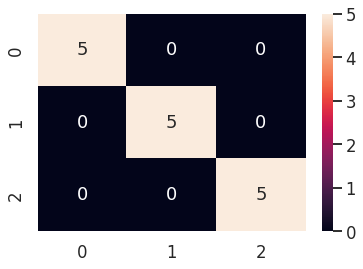

In [72]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

## Question 12

* Fit a logistic regression model with regularization. This can be a replica of a model that worked well in the exercises from week 4.
* Using `VotingClassifier`, fit the logistic regression model along with either the GratientBoostedClassifier or the AdaBoost model (or both) from questions 10 and 11.
* Determine the error as before and compare the results to the appropriate gradient boosted model(s).
* Plot the confusion matrix for the best model created in this set of exercises.

In [73]:
from sklearn.linear_model import LogisticRegressionCV

# L2 regularized logistic regression
LR_L2 = LogisticRegressionCV(Cs=5, cv=4, penalty='l2').fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Check the errors and confusion matrix for the logistic regression model.

In [74]:
y_pred = LR_L2.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



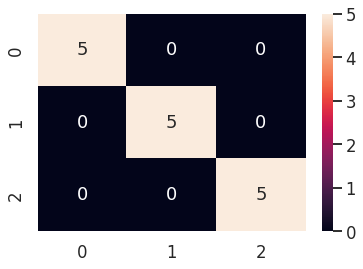

In [75]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

And now the stacked model.

In [76]:
from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('LR_L2', LR_L2), ('GBC', GV_GBC)]

# Though it wasn't done here, it is often desirable to train 
# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Finally the error on the voting classifier. We do a little better here than with either logistic regression or gradient boosted trees alone. However, the fact that logistic regression does almost as well as gradient boosted trees is an important reminder that it's good practice to try the simplest model first. In some cases, its performance will be good enough.

In [77]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



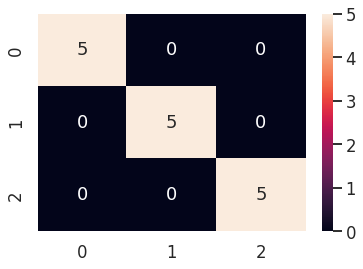

In [78]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')